# Chatbot using Seq2Seq LSTM Model

Import needed packages

In [1]:

import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import glob
from tensorflow.keras import layers , activations , models , preprocessing, utils
import os
import yaml
import pickle
from gensim.models import Word2Vec
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard

Load the Used Datasets

In [3]:
questions = list()
answers = list()

for filepath in glob.glob('./Datasets/*.yml'):
    stream = open( filepath , 'rb')
    docs = yaml.safe_load(stream)
    conversations = docs['conversations']
    for con in conversations:
        if len( con ) > 2 :
            questions.append(con[0])
            replies = con[ 1 : ]
            ans = ''
            for rep in replies:
                ans += ' ' + rep
            answers.append( ans )
        elif len( con )> 1:
            questions.append(con[0])
            answers.append(con[1])

answers_with_tags = list()
for i in range( len( answers ) ):
    if type( answers[i] ) == str:
        answers_with_tags.append( answers[i] )
    else:
        questions.pop( i )

answers = list()
for i in range( len( answers_with_tags ) ) :
    answers.append( '<START> ' + answers_with_tags[i] + ' <END>' )

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts( questions + answers )
VOCAB_SIZE = len( tokenizer.word_index )+1
print( 'VOCAB SIZE : {}'.format( VOCAB_SIZE ))


VOCAB SIZE : 1519


Create Tockenizer file

In [4]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


Prepare the data for Seq2Seq model

> Our model requires three arrays:

> `encoder_input_data` :
>> * Tokenizes the `questions`, and pad them to their maximum length.

> `decoder_input_data` :
>> * Tokenizes the `answers`, and pad them to their maximum length.

> `decoder_output_data` :
>> * Tokenizes the `answers`, and Remove the first element from all the `tokenized_answers`. This is the `<START>` element which we added earlier.

In [5]:


vocab = []
for word in tokenizer.word_index:
    vocab.append( word )

def tokenize( sentences ):
    tokens_list = []
    vocabulary = []
    for sentence in sentences:
        sentence = sentence.lower()
        sentence = re.sub( '[^a-zA-Z]', ' ', sentence )
        tokens = sentence.split()
        vocabulary += tokens
        tokens_list.append( tokens )
    return tokens_list , vocabulary

# encoder_input_data
tokenized_questions = tokenizer.texts_to_sequences( questions )
maxlen_questions = max( [ len(x) for x in tokenized_questions ] )
padded_questions = preprocessing.sequence.pad_sequences( tokenized_questions , maxlen=maxlen_questions , padding='post' )
encoder_input_data = np.array( padded_questions )
print( encoder_input_data.shape , maxlen_questions )

# decoder_input_data
tokenized_answers = tokenizer.texts_to_sequences( answers )
maxlen_answers = max( [ len(x) for x in tokenized_answers ] )
padded_answers = preprocessing.sequence.pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )
decoder_input_data = np.array( padded_answers )
print( decoder_input_data.shape , maxlen_answers )

# decoder_output_data
tokenized_answers = tokenizer.texts_to_sequences( answers )
for i in range(len(tokenized_answers)) :
    tokenized_answers[i] = tokenized_answers[i][1:]
padded_answers = preprocessing.sequence.pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )
onehot_answers = utils.to_categorical( padded_answers , VOCAB_SIZE )
decoder_output_data = np.array( onehot_answers )
print( decoder_output_data.shape )


(819, 13) 13
(819, 85) 85
(819, 85, 1519)


Split the data into training and validation sets

In [6]:
encoder_input_train, encoder_input_val, decoder_input_train, decoder_input_val, decoder_output_train, decoder_output_val = train_test_split(encoder_input_data, decoder_input_data, decoder_output_data, test_size=0.15,random_state=42)

print("Shape of encoder_input_train:", encoder_input_train.shape)
print("Shape of encoder_input_val:", encoder_input_val.shape)
print("Shape of decoder_input_train:", decoder_input_train.shape)
print("Shape of decoder_input_val:", decoder_input_val.shape)
print("Shape of decoder_output_train:", decoder_output_train.shape)
print("Shape of decoder_output_val:", decoder_output_val.shape)


Shape of encoder_input_train: (696, 13)
Shape of encoder_input_val: (123, 13)
Shape of decoder_input_train: (696, 85)
Shape of decoder_input_val: (123, 85)
Shape of decoder_output_train: (696, 85, 1519)
Shape of decoder_output_val: (123, 85, 1519)


Defining the Model
The model will have Embedding, LSTM and Dense layers.

1.   The `encoder_input_data` comes in the Embedding layer (`encoder_embedding` ). 
2.   The output of the Embedding layer goes to the LSTM cell which produces 2 state vectors ( `h` and `c` which are `encoder_states` )
3.   These states are set in the LSTM cell of the decoder.
4.   The decoder_input_data comes in through the Embedding layer.
5.   The Embeddings goes in LSTM cell ( which had the states ) to produce seqeunces.

In [7]:

encoder_inputs = tf.keras.layers.Input(shape=( maxlen_questions , ))
encoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 200 , mask_zero=True ) (encoder_inputs)
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM( 200 , return_state=True )( encoder_embedding )
encoder_states = [ state_h , state_c ]

decoder_inputs = tf.keras.layers.Input(shape=( maxlen_answers ,  ))
decoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 200 , mask_zero=True) (decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM( 200 , return_state=True , return_sequences=True )
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
decoder_dense = tf.keras.layers.Dense( VOCAB_SIZE , activation=tf.keras.activations.softmax ) 
output = decoder_dense ( decoder_outputs )

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 85)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 13, 200)      303800      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 85, 200)      303800      ['input_2[0][0]']                
                                                                                              

Define Checkpoint to save the best model with lowest validation loss

In [8]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="LSTM_SEQ2SEQ_Chatbot.h5",
    monitor='val_loss',
    verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # Metric to monitor
    patience=5, # Number of epochs with no improvement after which training will be stopped
    verbose=1
)

Insert tensorboard callback here

In [9]:
log_dir = "./Run/"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

* `Train the Seq2Seq Model`

In [10]:

history = model.fit([encoder_input_train , decoder_input_train], decoder_output_train,validation_data=([encoder_input_val , decoder_input_val],decoder_output_val), batch_size=64, epochs=250,callbacks=[checkpoint_callback,early_stopping, tensorboard_callback] ) 


Epoch 1/250
11/11 [==============================] - ETA: 0s - loss: 2.1459 - accuracy: 0.0743
Epoch 1: saving model to LSTM_SEQ2SEQ_Chatbot.h5
11/11 [==============================] - 20s 480ms/step - loss: 2.1459 - accuracy: 0.0743 - val_loss: 2.1104 - val_accuracy: 0.0592
Epoch 2/250
11/11 [==============================] - ETA: 0s - loss: 1.8557 - accuracy: 0.0601
Epoch 2: saving model to LSTM_SEQ2SEQ_Chatbot.h5
11/11 [==============================] - 1s 112ms/step - loss: 1.8557 - accuracy: 0.0601 - val_loss: 1.7563 - val_accuracy: 0.0570
Epoch 3/250
11/11 [==============================] - ETA: 0s - loss: 1.7098 - accuracy: 0.0511
Epoch 3: saving model to LSTM_SEQ2SEQ_Chatbot.h5
11/11 [==============================] - 1s 96ms/step - loss: 1.7098 - accuracy: 0.0511 - val_loss: 1.7356 - val_accuracy: 0.0428
Epoch 4/250
10/11 [==========================>...] - ETA: 0s - loss: 1.6775 - accuracy: 0.0578
Epoch 4: saving model to LSTM_SEQ2SEQ_Chatbot.h5
11/11 [========================

Plot graph of accuracy and loss over time for training and validation sets.

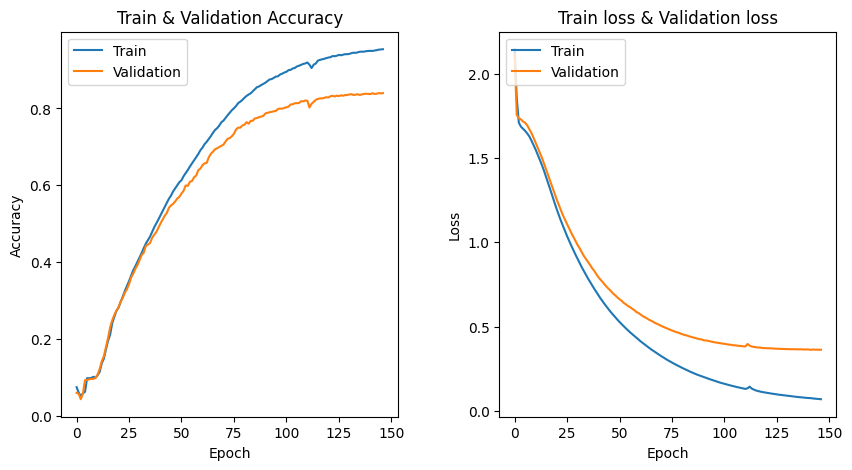

In [13]:
# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Train & Validation Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train','Validation'], loc='upper left')

# plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Train loss & Validation loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train','Validation'], loc='upper left')

# adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# show the plot
plt.show()

Define a function named `make_inference_models` that creates and returns two inference models: an `encoder model` and a `decoder model`.

* The `encoder model` accepts the `encoder_input_data` as input and returns the `encoder_states` as output.
* The `decoder model` accepts the `decoder_input_data` and initial `decoder_states` as input and returns the `decoder_outputs` and `decoder_states` as output.

In [14]:

def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)

    decoder_state_input_h = tf.keras.layers.Input(shape=( 200 ,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 200 ,))

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.models.Model([decoder_inputs] + decoder_states_inputs,[decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model


Define a function for converting a sentence into a sequence of tokens that can be fed into the model for further processing, such as 

`making predictions` or `generating responses`

In [15]:

def str_to_tokens( sentence : str ):
    words = sentence.lower().split()
    tokens_list = list()
    for word in words:
        tokens_list.append( tokenizer.word_index[ word ] ) 
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=maxlen_questions , padding='post')


Make a basic conversation loop where the user enters a question, and the model generates a response based on the given input to test the Chatbot.

In [16]:

enc_model , dec_model = make_inference_models()

for _ in range(10):
    userInput = input( 'Enter question : ' )
    states_values = enc_model.predict( str_to_tokens( userInput ),verbose=0 )
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = tokenizer.word_index['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values,verbose=0 )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        for word , index in tokenizer.word_index.items() :
            if sampled_word_index == index :
                decoded_translation += ' {}'.format( word )
                sampled_word = word
        
        if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
            stop_condition = True
            
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 
    print("You: ", userInput)
    print("Bot: ", decoded_translation[:-3] )


You:  hello
Bot:   hello how can i help you today 
You:  how are you
Bot:   i am fine thanks 
You:  tell me about the pyramids
Bot:   the pyramids of giza are one of the most recognizable symbols of egypt and the ancient world they were built as tombs for pharaohs and their consorts during the old and middle kingdom periods 
You:  thanks
Bot:   you're welcome and thank you for your kind words 
You:  thank you
Bot:   you're welcome and thank you for your kind words 
You:  bye
Bot:   goodbye have a great day and enjoy your stay in egypt 
You:  end
Bot:   robots rule 
You:  
Bot:   robots rule 
You:  
Bot:   robots rule 
You:  
Bot:   robots rule 
